In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import os
import sys; sys.path.insert(0, os.path.abspath("../"))
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from dataset.dataset import SkinLesion_Dataset, SegExamples
from pipeline.preprocessing import SkinLesionPreprocessing
from pipeline.feature_extraction import FeaturesExtraction

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import pickle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
train_df = pd.read_feather("../data/three_class/train_all_feat.f")
val_df = pd.read_feather("../data/three_class/val_all_feat.f")
train_shape = train_df.shape
val_shape = val_df.shape
print(f'train shape: {train_shape}, val shape: {val_shape}')

train shape: (5082, 144), val shape: (1270, 144)


In [4]:
print(np.unique(train_df.label.values, return_counts=True))
print(np.unique(val_df.label.values, return_counts= True))

(array(['bcc', 'mel', 'scc'], dtype=object), array([1993, 2713,  376]))
(array(['bcc', 'mel', 'scc'], dtype=object), array([498, 678,  94]))


In [5]:
train_df.replace({'bcc': 0, 'mel': 1, 'scc': 2}, inplace=True)
val_df.replace({'bcc': 0, 'mel': 1, 'scc': 2}, inplace=True)

df_train = train_df.iloc[:train_shape[0], :].sample(frac=1, random_state=42)
df_val = val_df.iloc[:val_shape[0], :].sample(frac=1, random_state=42)
# df_val

X_train, y_train = df_train.iloc[:, :(train_shape[1]-1)].to_numpy(dtype=np.float32), df_train.iloc[:, (train_shape[1]-1)].to_numpy()
X_test, y_test = df_val.iloc[:, :(val_shape[1]-1)].to_numpy(dtype= np.float32), df_val.iloc[:, (val_shape[1]-1)].to_numpy()

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}')

X_train: (5082, 143), y_train: (5082,), X_test: (1270, 143), y_test: (1270,)


In [8]:

classifier = svm.SVC()
C_range = np.logspace(-2, 10, 6)
gamma_range = np.logspace(-9, 3, 5)
# param_grid = dict(gamma=gamma_range, C=C_range)
param_grid = {'classifier__C': C_range,
                'classifier__gamma': [0.001],
              'classifier__kernel': ['rbf']}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

pipe = Pipeline([('scaler', StandardScaler()),('classifier', classifier)])
grid_search = GridSearchCV(pipe, param_grid, cv=cv, refit = True, verbose = 1, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

print("TRAIN- The best parameters are %s with an f1-score of %0.4f"%(grid_search.best_params_, grid_search.best_score_))
y_train_predicted = grid_search.predict(X_train)
y_test_predicted =  grid_search.predict(X_test)
print('F1 Score of train data: %0.4f' %f1_score(y_train,y_train_predicted,average='weighted'), f'Acc: {accuracy_score(y_train, y_train_predicted)}')
print('F1 Score of test data: %0.4f' %f1_score(y_test,y_test_predicted,average='weighted'), f'Acc: {accuracy_score(y_test, y_test_predicted)}')

INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU


Fitting 10 folds for each of 6 candidates, totalling 60 fits


INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerat

TRAIN- The best parameters are {'classifier__C': 630.957344480193, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'} with an f1-score of 0.8356
F1 Score of train data: 0.9326 Acc: 0.9340810704447068
F1 Score of test data: 0.8361 Acc: 0.8393700787401575


INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU


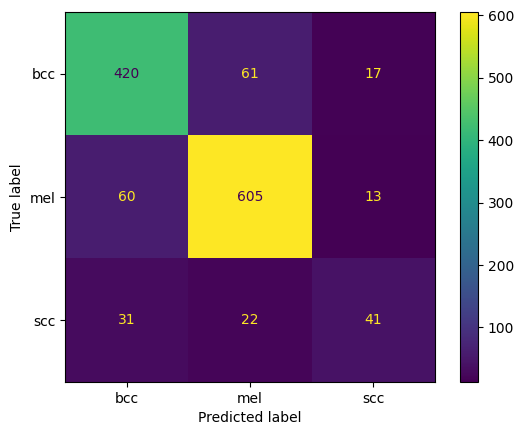

In [9]:
# confusion matrix
# cm = confusion_matrix(y_test, y_test_predicted)

# {'bcc': 0 (498), 'mel': 1 (678), 'scc': 2 (94)}
ConfusionMatrixDisplay.from_estimator(grid_search, X_test, y_test, display_labels=['bcc', 'mel', 'scc'])
plt.show()

### With local color features

In [5]:
train_df_1 = pd.read_feather("../data/three_class/train_all_feat.f")
train_df_2 = pd.read_feather("../data/three_class/train_color_local_feat.f")
val_df_1 = pd.read_feather("../data/three_class/val_all_feat.f")
val_df_2 = pd.read_feather("../data/three_class/val_color_local_feat.f")


print(f'train shape: {train_df_1.shape}, val shape: {val_df_1.shape}')
print(f'train color: {train_df_2.shape}, val color: {val_df_2.shape}')

train shape: (5082, 144), val shape: (1270, 144)
train color: (5082, 61), val color: (1270, 61)


In [6]:
train_df = pd.concat([train_df_2.iloc[:,:60], train_df_1], axis=1)
val_df = pd.concat([val_df_2.iloc[:, :60], val_df_1], axis=1)
train_shape = train_df.shape
val_shape = val_df.shape
print(f'train shape: {train_shape}, val shape: {val_shape}')

print(np.unique(train_df.label.values, return_counts=True))
print(np.unique(val_df.label.values, return_counts= True))

train shape: (5082, 204), val shape: (1270, 204)
(array(['bcc', 'mel', 'scc'], dtype=object), array([1993, 2713,  376]))
(array(['bcc', 'mel', 'scc'], dtype=object), array([498, 678,  94]))


In [7]:
train_df.replace({'bcc': 0, 'mel': 1, 'scc': 2}, inplace=True)
val_df.replace({'bcc': 0, 'mel': 1, 'scc': 2}, inplace=True)

df_train = train_df.iloc[:train_shape[0], :].sample(frac=1, random_state=42)
df_val = val_df.iloc[:val_shape[0], :].sample(frac=1, random_state=42)
# df_val

X_train, y_train = df_train.iloc[:, :(train_shape[1]-1)].to_numpy(dtype=np.float32), df_train.iloc[:, (train_shape[1]-1)].to_numpy()
X_test, y_test = df_val.iloc[:, :(val_shape[1]-1)].to_numpy(dtype= np.float32), df_val.iloc[:, (val_shape[1]-1)].to_numpy()

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}')

X_train: (5082, 203), y_train: (5082,), X_test: (1270, 203), y_test: (1270,)


In [9]:
C_range

array([1.e-02, 1.e+04, 1.e+10])

In [10]:
classifier = svm.SVC()
C_range = np.logspace(-2, 1, 3)
gamma_range = np.logspace(-9, 3, 3)
# param_grid = dict(gamma=gamma_range, C=C_range)
param_grid = {'classifier__C': C_range,
                'classifier__gamma': gamma_range,
              'classifier__kernel': ['rbf']}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

pipe = Pipeline([('scaler', StandardScaler()),('classifier', classifier)])
grid_search = GridSearchCV(pipe, param_grid, cv=cv, refit = True, verbose = 1, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

print("TRAIN- The best parameters are %s with an f1-score of %0.4f"%(grid_search.best_params_, grid_search.best_score_))
y_train_predicted = grid_search.predict(X_train)
y_test_predicted =  grid_search.predict(X_test)
print('F1 Score of train data: %0.4f' %f1_score(y_train,y_train_predicted,average='weighted'), f'Acc: {accuracy_score(y_train, y_train_predicted)}')
print('F1 Score of test data: %0.4f' %f1_score(y_test,y_test_predicted,average='weighted'), f'Acc: {accuracy_score(y_test, y_test_predicted)}')

INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU


Fitting 10 folds for each of 9 candidates, totalling 90 fits


INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict: running accel

TRAIN- The best parameters are {'classifier__C': 10.0, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'} with an f1-score of 0.7991
F1 Score of train data: 0.8323 Acc: 0.8534041715859898
F1 Score of test data: 0.7847 Acc: 0.8102362204724409


INFO:root:sklearn.svm.SVC.predict: running accelerated version on CPU


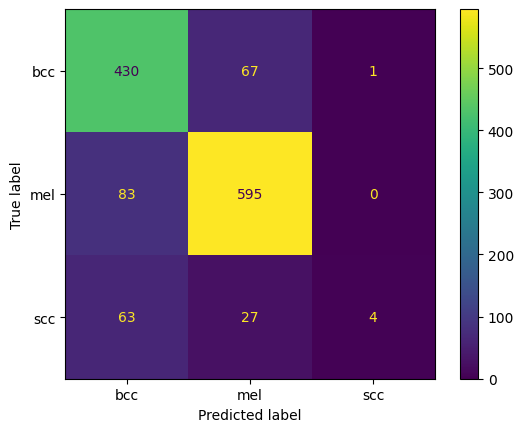

In [11]:
ConfusionMatrixDisplay.from_estimator(grid_search, X_test, y_test, display_labels=['bcc', 'mel', 'scc'])
plt.show()